# ML prediction (OLS, Regression, Random Forest, XGB)

- Project:        PLE vs. SU prediction 
- Author:         Carolyn Amir 
- Code Status:    working

In [2]:
!pip install xgboost


     |████████████████████████████████| 2.1 MB 2.3 MB/s eta 0:00:01


In [3]:
import xgboost
print(xgboost.__version__)

2.1.2


In [5]:
!pip install shap


     |████████████████████████████████| 459 kB 7.2 MB/s eta 0:00:01


In [3]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import StandardScaler 

import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#pd.reset_option('all')

### Import raw data

In [5]:
# setup path to folders
project = Path("/Users/carolynamir/Documents/ABCD")

In [6]:
# male = pd.read_csv(project / 'allphenotypes_male_harmonized_fp_zscore.csv')
# female = pd.read_csv(project / 'allphenotypes_female_harmonized_fp_zscore.csv')

In [7]:
subcor = pd.read_csv(project / "master_preds_11_15_24_correct.csv")

In [5]:
# df = female
# df['Sex'] = df['Sex'].map({'M': 1, 'F': 0})

In [22]:
subcor.head(5)

src_subject_id  X  demo_sex_v2  interview_age  site_id_l.x  PLEBother  \
0  NDAR_INV003RTV85  1          2.0          131.0          NaN        0.0   
1  NDAR_INV005V6D2C  2          2.0          121.0          NaN        0.0   
2  NDAR_INV007W6H7B  3          1.0          126.0          NaN        7.0   
3  NDAR_INV00BD7VDC  4          1.0          112.0          NaN        0.0   
4  NDAR_INV00CY2MDM  5          1.0          130.0          NaN        0.0   

   income_recode  PLESum  striatum     vmPFC mri_info_manufacturer  \
0            2.0     0.0 -0.714715 -0.850872               SIEMENS   
1            NaN     0.0  1.043689  1.143153    GE MEDICAL SYSTEMS   
2            3.0     7.0 -0.635862 -1.054433    GE MEDICAL SYSTEMS   
3            3.0     0.0  0.101119 -2.412963               SIEMENS   
4            1.0     0.0  0.163403  0.072817               SIEMENS   

   rsfmri_DMN_DMN  rsfmri_CON_CON  rsfmri_cor_ngd_au_scs_ptlh  \
0        0.345007        0.453705                   -0.172777   
1             NaN             NaN                         NaN   
2        0.273000        0.350964                   -0.091419   
3        0.260493        0.301307                   -0.113760   
4        0.251705        0.211683                   -0.019446   

   rsfmri_cor_ngd_fopa_scs_aalh  rsfmri_cor_ngd_fopa_scs_aarh  \
0                      0.061738                     -0.100553   
1                           NaN                           NaN   
2                     -0.039787                      0.022555   
3                     -0.105930                      0.059647   
4                      0.038358                      0.002575   

   rsfmri_cor_ngd_au_scs_ptrh  ave_prefrontal_thickness  dmri_rsirnt_fib_fmin  \
0                    0.178955                  2.853500              0.821149   
1                         NaN                  2.637667              0.799618   
2                   -0.012228                  2.856000              0.659614   
3                   -0.002627                  2.768333              0.799683   
4                   -0.137203                  2.809333              0.795230   

   dmri_dtitdgm_cdsn_ptisrh  r_amyg_Neg_Neu  l_amyg_Neg_Neu  l_hipp_Neg_Neu  \
0                  0.798673        0.055381        0.212708       -0.359891   
1                  0.770695             NaN             NaN             NaN   
2                  0.777804        0.134794        0.245996        0.036286   
3                  0.839837       -0.347294        0.156462       -1.030973   
4                  0.808484        0.056610        0.252010        0.049148   

   r_hipp_Neg_Neu  r_fusi_Neg_Neu  IFG_SST_vsGo outcome_group  \
0       -0.082504       -0.002187      0.034582           NaN   
1             NaN             NaN           NaN          none   
2       -0.055687        0.246702      0.414206          none   
3       -0.518090       -0.302584      0.276121          none   
4        0.107718        0.522342     -0.065527          none   

  outcome_group_distress outcome_group_distress_karcher  IFG_SST_vsBL  
0                    NaN                            NaN      0.235603  
1                   none                           none           NaN  
2                   none                           none      0.207694  
3                   none                           none      0.149905  
4                   none                           none      0.273630

In [8]:
subcor = subcor.drop(subcor.index[0]).reset_index(drop=True)

In [19]:
#subcor = subcor.drop(subcor.columns[0], axis=1)

In [7]:
# df['CTQ_Neglect'] = df['CTQ_PN'] + df['CTQ_EN']
# df['CTQ_Abuse'] = df['CTQ_PA'] + df['CTQ_EA'] + df['CTQ_SA']

In [56]:
### define types of cols

rsfMRI = ['rsfmri_DMN_DMN', "rsfmri_CON_CON", "rsfmri_cor_ngd_au_scs_ptlh", "rsfmri_cor_ngd_fopa_scs_aalh", "rsfmri_cor_ngd_fopa_scs_aarh", "rsfmri_cor_ngd_au_scs_ptrh"]
MID = ['striatum', 'vmPFC']
struct = ['ave_prefrontal_thickness', 'dmri_rsirnt_fib_fmin', 'dmri_dtitdgm_cdsn_ptisrh']
eNback = ["r_amyg_Neg_Neu", "l_amyg_Neg_Neu", "l_hipp_Neg_Neu", "r_hipp_Neg_Neu", "r_fusi_Neg_Neu"]
SST = ["IFG_SST_vsGo", "IFG_SST_vsBL"]

BL_PLEs = ['PLESum','PLEBother']

Demo = ['demo_sex_v2', 'interview_age','income_recode']

outcomes = ['outcome_group','outcome_group_distress','outcome_group_distress_karcher']

In [72]:
X_cols = rsfMRI + MID + struct + eNback + SST + BL_PLEs + Demo

In [74]:
X_cols_2 = rsfMRI + MID + struct + eNback + SST 

In [11]:
print(type(X_cols))  # Should output <class 'list'>
print(X_cols)  # Should output something like ['CTQ_PN', 'CTQ_EN']


<class 'list'>
['rsfmri_DMN_DMN', 'rsfmri_CON_CON', 'rsfmri_cor_ngd_au_scs_ptlh', 'rsfmri_cor_ngd_fopa_scs_aalh', 'rsfmri_cor_ngd_fopa_scs_aarh', 'rsfmri_cor_ngd_au_scs_ptrh', 'striatum', 'vmPFC', 'ave_prefrontal_thickness', 'dmri_rsirnt_fib_fmin', 'dmri_dtitdgm_cdsn_ptisrh', 'r_amyg_Neg_Neu', 'l_amyg_Neg_Neu', 'l_hipp_Neg_Neu', 'r_hipp_Neg_Neu', 'r_fusi_Neg_Neu', 'IFG_SST_vsGo', 'IFG_SST_vsBL', 'PLESum', 'PLEBother', 'demo_sex_v2', 'interview_age', 'site_id_l.x', 'income_recode']


In [37]:
#preds = subcor.dropna(subset=X_cols)

In [58]:
# This keeps all rows, even those with NaN values in X_cols
preds = subcor[X_cols]


In [107]:
all_cols = rsfMRI + MID + struct + eNback + SST + BL_PLEs + Demo + outcomes
df = subcor[all_cols]

In [108]:
df.columns

Index(['rsfmri_DMN_DMN', 'rsfmri_CON_CON', 'rsfmri_cor_ngd_au_scs_ptlh',
       'rsfmri_cor_ngd_fopa_scs_aalh', 'rsfmri_cor_ngd_fopa_scs_aarh',
       'rsfmri_cor_ngd_au_scs_ptrh', 'striatum', 'vmPFC',
       'ave_prefrontal_thickness', 'dmri_rsirnt_fib_fmin',
       'dmri_dtitdgm_cdsn_ptisrh', 'r_amyg_Neg_Neu', 'l_amyg_Neg_Neu',
       'l_hipp_Neg_Neu', 'r_hipp_Neg_Neu', 'r_fusi_Neg_Neu', 'IFG_SST_vsGo',
       'IFG_SST_vsBL', 'PLESum', 'PLEBother', 'demo_sex_v2', 'interview_age',
       'income_recode', 'outcome_group', 'outcome_group_distress',
       'outcome_group_distress_karcher'],
      dtype='object')

In [10]:
df = df.dropna(subset=X_cols)

In [14]:
print(preds.columns.to_list())

['rsfmri_DMN_DMN', 'rsfmri_CON_CON', 'rsfmri_cor_ngd_au_scs_ptlh', 'rsfmri_cor_ngd_fopa_scs_aalh', 'rsfmri_cor_ngd_fopa_scs_aarh', 'rsfmri_cor_ngd_au_scs_ptrh', 'striatum', 'vmPFC', 'ave_prefrontal_thickness', 'dmri_rsirnt_fib_fmin', 'dmri_dtitdgm_cdsn_ptisrh', 'r_amyg_Neg_Neu', 'l_amyg_Neg_Neu', 'l_hipp_Neg_Neu', 'r_hipp_Neg_Neu', 'r_fusi_Neg_Neu', 'IFG_SST_vsGo', 'IFG_SST_vsBL', 'PLESum', 'PLEBother', 'demo_sex_v2', 'interview_age', 'site_id_l.x', 'income_recode']


In [12]:
# """ Drop CTQ_Total that is too small """
# df = df[df['CTQ_Total'] >= 25]

In [45]:
preds.head

<bound method NDFrame.head of        rsfmri_DMN_DMN  rsfmri_CON_CON  rsfmri_cor_ngd_au_scs_ptlh  \
0                 NaN             NaN                         NaN   
1            0.273000        0.350964                   -0.091419   
2            0.260493        0.301307                   -0.113760   
3            0.251705        0.211683                   -0.019446   
4            0.352653        0.323760                    0.178744   
5            0.208296        0.261847                   -0.129204   
6            0.215313        0.374498                   -0.084317   
7                 NaN             NaN                         NaN   
8            0.387661        0.359220                   -0.042644   
9            0.220592        0.362423                   -0.125546   
10           0.243123        0.341170                    0.067529   
11           0.299897        0.261614                    0.015908   
12           0.239436        0.345634                   -0.151976   
13  

In [46]:
preds = preds.drop(preds.index[0]).reset_index(drop=True)

In [61]:
preds.shape

(11930, 23)

In [48]:
# # Generate the histogram
# plt.hist(preds['CTQ_Total'], bins='auto', edgecolor='black')  # 'auto' selects the number of bins automatically

# # Add labels and title
# plt.xlabel('Values')
# plt.ylabel('Frequency')
# plt.title('Histogram of Total CTQ in Female Analysis Sample')

# # Show the plot
# plt.show()

KeyError: 'CTQ_Total'

In [109]:
print(df[feature_cols].dtypes)  # Check data types for feature columns
print(df[outcome_var].dtype)   # Check data type for the outcome column

rsfmri_DMN_DMN                  float64
rsfmri_CON_CON                  float64
rsfmri_cor_ngd_au_scs_ptlh      float64
rsfmri_cor_ngd_fopa_scs_aalh    float64
rsfmri_cor_ngd_fopa_scs_aarh    float64
rsfmri_cor_ngd_au_scs_ptrh      float64
striatum                        float64
vmPFC                           float64
ave_prefrontal_thickness        float64
dmri_rsirnt_fib_fmin            float64
dmri_dtitdgm_cdsn_ptisrh        float64
r_amyg_Neg_Neu                  float64
l_amyg_Neg_Neu                  float64
l_hipp_Neg_Neu                  float64
r_hipp_Neg_Neu                  float64
r_fusi_Neg_Neu                  float64
IFG_SST_vsGo                    float64
IFG_SST_vsBL                    float64
PLESum                          float64
PLEBother                       float64
outcome_group                    object
outcome_group_distress           object
dtype: object
object


In [111]:
df_copy = df.copy()  # Create a copy to avoid warnings
df[feature_cols] = df_copy[feature_cols].apply(pd.to_numeric, errors='coerce')
#df[outcome_var] = pd.to_numeric(df[outcome_var], errors='coerce')


/var/folders/q5/8yyjy1vs02d36j1g7wwgthw40000gp/T/ipykernel_75150/197190474.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[X_cols] = df[X_cols].apply(pd.to_numeric, errors='coerce')


In [166]:
df= df_copy

In [161]:
df = df.dropna(subset=X_cols + [outcome_var]) 

In [163]:
outcome_var = 'outcome_group'
df = df.dropna(subset=X_cols + [outcome_var])  # Drop rows with NaN in relevant columns

In [165]:
print(df[outcome_var])

Series([], Name: outcome_group, dtype: float64)


In [119]:
# Print non-NA count for each column in feature_cols along with the column name
non_na_counts = df_copy[X_cols].notna().sum()

# Print each column's non-NA count
for col, count in non_na_counts.items():
    print(f"{col}: {count}")

rsfmri_DMN_DMN: 9639
rsfmri_CON_CON: 9636
rsfmri_cor_ngd_au_scs_ptlh: 9639
rsfmri_cor_ngd_fopa_scs_aalh: 9639
rsfmri_cor_ngd_fopa_scs_aarh: 9633
rsfmri_cor_ngd_au_scs_ptrh: 9639
striatum: 11430
vmPFC: 11430
ave_prefrontal_thickness: 11432
dmri_rsirnt_fib_fmin: 10436
dmri_dtitdgm_cdsn_ptisrh: 10436
r_amyg_Neg_Neu: 7927
l_amyg_Neg_Neu: 7927
l_hipp_Neg_Neu: 7927
r_hipp_Neg_Neu: 7927
r_fusi_Neg_Neu: 7927
IFG_SST_vsGo: 8289
IFG_SST_vsBL: 8290
PLESum: 11430
PLEBother: 11430
demo_sex_v2: 11430
interview_age: 11429
income_recode: 10407


In [49]:
df = df_copy.drop(columns=['site_id_l.x'])

In [52]:
df_copy = df.copy()

In [53]:
print(df[col].dropna().shape[0])  # Non-NaN count for a feature column
print(df[outcome_var].dropna().shape[0])  # Non-NaN count for the outcome variable

9639
11930


In [159]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the target variable
df[outcome_var] = label_encoder.fit_transform(df[outcome_var])

# Check the mapping
print(label_encoder.classes_)  # ['PLE_distress_only', 'SU_only', 'none', 'both']

['PLE_only' 'SU_only' 'both' 'none']


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit and transform the target variable
df[outcome_var] = label_encoder.fit_transform(df[outcome_var])

# Check the mapping
print(label_encoder.classes_)  # ['PLE_distress_only', 'SU_only', 'none']

In [70]:

from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
import pandas as pd

# Assuming 'df' is your DataFrame containing the features and outcome variable

outcome_var = 'outcome_group_distress_karcher'
feature_cols = X_cols  # Exclude the outcome variable

corr_pvals = []
corr_coeffs = []

for col in feature_cols:
    corr, pval = pearsonr(df[col], df[outcome_var])
    corr_pvals.append(pval)
    corr_coeffs.append(corr)

# Perform FDR correction
fdr_method = 'fdr_bh'  # Use 'fdr_by' for Benjamini-Yekutieli procedure
fdr_threshold = 0.05

rejected, pvals_corrected, _, _ = multipletests(corr_pvals, alpha=fdr_threshold, method=fdr_method)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Feature': feature_cols,
    'Correlation': corr_coeffs,
    'P-value': corr_pvals,
    'Adjusted P-value': pvals_corrected,
    'Significant': rejected
})

# Sort the results by the adjusted p-values
results_df.sort_values('Adjusted P-value', inplace=True)

# Display the significant features
significant_features = results_df[results_df['Significant']]
print("Significant features after FDR correction:")
print(significant_features)

Significant features after FDR correction:
          Feature  Correlation       P-value  Adjusted P-value  Significant
19      PLEBother    -0.102975  5.054497e-15      1.162534e-13         True
18         PLESum    -0.100952  1.706317e-14      1.962264e-13         True
20    demo_sex_v2    -0.092330  2.334664e-12      1.789909e-11         True
22  income_recode     0.056302  1.949079e-05      1.120720e-04         True
16   IFG_SST_vsGo    -0.034211  9.494377e-03      4.367414e-02         True


In [73]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
import pandas as pd

# Assuming 'df' is your DataFrame containing the features and outcome variable

outcome_var = 'outcome_group_distress_karcher'
feature_cols = X_cols  # Exclude the outcome variable

corr_pvals = []
corr_coeffs = []

# Compute Pearson correlation and p-values
for col in feature_cols:
    corr, pval = pearsonr(df[col], df[outcome_var])
    corr_pvals.append(pval)
    corr_coeffs.append(corr)

# Perform FDR correction
fdr_method = 'fdr_bh'  # Use 'fdr_by' for Benjamini-Yekutieli procedure
fdr_threshold = 0.05

rejected, pvals_corrected, _, _ = multipletests(corr_pvals, alpha=fdr_threshold, method=fdr_method)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Feature': feature_cols,
    'Correlation': corr_coeffs,
    'P-value': corr_pvals,
    'Adjusted P-value': pvals_corrected,
    'Significant': rejected
})

# Sort the results by the adjusted p-values
results_df.sort_values('Adjusted P-value', inplace=True)

# Display features significant before FDR correction (raw p-value < 0.05)
pre_fdr_significant = results_df[results_df['P-value'] < 0.05]
print("Features significant before FDR correction (raw p-value < 0.05):")
print(pre_fdr_significant)

# Display features significant after FDR correction
post_fdr_significant = results_df[results_df['Significant']]
print("\nFeatures significant after FDR correction:")
print(post_fdr_significant)


Features significant before FDR correction (raw p-value < 0.05):
                 Feature  Correlation       P-value  Adjusted P-value  \
19             PLEBother    -0.102975  5.054497e-15      1.162534e-13   
18                PLESum    -0.100952  1.706317e-14      1.962264e-13   
20           demo_sex_v2    -0.092330  2.334664e-12      1.789909e-11   
22         income_recode     0.056302  1.949079e-05      1.120720e-04   
16          IFG_SST_vsGo    -0.034211  9.494377e-03      4.367414e-02   
1         rsfmri_CON_CON     0.028223  3.239170e-02      1.168301e-01   
9   dmri_rsirnt_fib_fmin     0.027728  3.555700e-02      1.168301e-01   

    Significant  
19         True  
18         True  
20         True  
22         True  
16         True  
1         False  
9         False  

Features significant after FDR correction:
          Feature  Correlation       P-value  Adjusted P-value  Significant
19      PLEBother    -0.102975  5.054497e-15      1.162534e-13         True
18        

In [75]:
#try same thing but without demo data

# Assuming 'df' is your DataFrame containing the features and outcome variable

outcome_var = 'outcome_group_distress_karcher'
feature_cols = X_cols_2  # Exclude the outcome variable

corr_pvals = []
corr_coeffs = []

# Compute Pearson correlation and p-values
for col in feature_cols:
    corr, pval = pearsonr(df[col], df[outcome_var])
    corr_pvals.append(pval)
    corr_coeffs.append(corr)

# Perform FDR correction
fdr_method = 'fdr_bh'  # Use 'fdr_by' for Benjamini-Yekutieli procedure
fdr_threshold = 0.05

rejected, pvals_corrected, _, _ = multipletests(corr_pvals, alpha=fdr_threshold, method=fdr_method)

# Create a DataFrame to store the results
results_df = pd.DataFrame({
    'Feature': feature_cols,
    'Correlation': corr_coeffs,
    'P-value': corr_pvals,
    'Adjusted P-value': pvals_corrected,
    'Significant': rejected
})

# Sort the results by the adjusted p-values
results_df.sort_values('Adjusted P-value', inplace=True)

# Display features significant before FDR correction (raw p-value < 0.05)
pre_fdr_significant = results_df[results_df['P-value'] < 0.05]
print("Features significant before FDR correction (raw p-value < 0.05):")
print(pre_fdr_significant)

# Display features significant after FDR correction
post_fdr_significant = results_df[results_df['Significant']]
print("\nFeatures significant after FDR correction:")
print(post_fdr_significant)


Features significant before FDR correction (raw p-value < 0.05):
                 Feature  Correlation   P-value  Adjusted P-value  Significant
16          IFG_SST_vsGo    -0.034211  0.009494          0.170899        False
1         rsfmri_CON_CON     0.028223  0.032392          0.213342        False
9   dmri_rsirnt_fib_fmin     0.027728  0.035557          0.213342        False

Features significant after FDR correction:
Empty DataFrame
Columns: [Feature, Correlation, P-value, Adjusted P-value, Significant]
Index: []


### Split up training and test set 

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
#df = pd.read_csv("your_dataframe.csv")

# Separate target variable (y) and predictors (X)
y = df["outcome_group_distress_karcher"]
X = df[X_cols_2]  # Use the dynamically defined X_cols_2

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Define the training and testing sets

In [77]:
# Assuming that df is your DataFrame and y is the target variable
X = df[X_cols_2]
y = df['outcome_group_distress_karcher']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

from sklearn.preprocessing import StandardScaler
 
# Define the scaler
scaler = StandardScaler()

# Fit on the training set
scaler.fit(X_train)

# Transform both the training set and the test set
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Bootstrap the null CI of chance level

In [78]:
from sklearn.utils import resample

# Initialize a list to hold the bootstrapped metrics
bootstrapped_metrics_mse = []
bootstrapped_metrics_r2 = []

# Number of bootstrap iterations
n_bootstrap = 1000

# Perform bootstrapping
for _ in range(n_bootstrap):
    # Resample the data with replacement
    y_train_resampled = resample(y_train)

    # Calculate the null model metric on the resampled data
    y_train_pred_null = np.full(y_train_resampled.shape, y_train_resampled.mean())
    mse_null = mean_squared_error(y_train_resampled, y_train_pred_null)
    r2_null = r2_score(y_train_resampled, y_train_pred_null)

    # Add the metric to the list of bootstrapped metrics
    bootstrapped_metrics_mse.append(mse_null)
    bootstrapped_metrics_r2.append(r2_null)

# Calculate the 2.5th and 97.5th percentiles of the bootstrapped metrics to get the 95% CI
lower_mse = np.percentile(bootstrapped_metrics_mse, 2.5)
upper_mse = np.percentile(bootstrapped_metrics_mse, 97.5)
lower_r2 = np.percentile(bootstrapped_metrics_r2, 2.5)
upper_r2 = np.percentile(bootstrapped_metrics_r2, 97.5)

print(f'95% Confidence Interval for chance level: ({lower_mse}, {upper_mse})')
print(f'95% Confidence Interval for chance level: ({lower_r2}, {upper_r2})')

95% Confidence Interval for chance level: (0.23046252559279914, 0.30466896840771923)
95% Confidence Interval for chance level: (0.0, 0.0)


### Baseline Model - Standard OLS, no tuning

Mean squared error: 0.28
Mean absolute error: 0.21
Coefficient of determination: -0.00


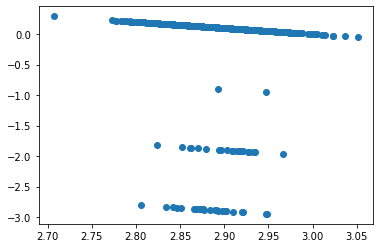

<AxesSubplot:xlabel='outcome_group_distress_karcher'>

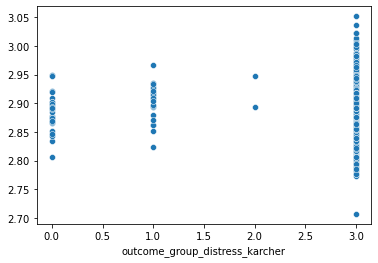

In [79]:
#Build simple linear regression
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)

#Show success metrics
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
print("Coefficient of determination: %.2f" % r2_score(y_test, y_pred))

#Plot residuals -- roughly centered around 0, but with weird diag lines bc ratings are not continuous
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.show()

sns.scatterplot(x=y_test, y=y_pred)

### Lasso (L1 Regression)

In [80]:
#basically no predictive utility of these neuroimaging measures 

from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# Standardize the features (important for Lasso regularization)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit the Lasso model
alpha_value = 0.01  # You can adjust the alpha parameter based on your needs
lasso = Lasso(alpha=alpha_value)
lasso.fit(X_train_scaled, y_train)
y_train_pred_lasso = lasso.predict(X_train)
y_test_pred_lasso = lasso.predict(X_test)

# Calculate MSE
train_mse_lasso = mean_squared_error(y_train, y_train_pred_lasso)
test_mse_lasso = mean_squared_error(y_test, y_test_pred_lasso)

print(f'Training MSE: {train_mse_lasso}')
print(f'Test MSE: {test_mse_lasso}')

# Calculate R2 Score
r2_train_lasso = r2_score(y_train, y_train_pred_lasso)
r2_test_lasso = r2_score(y_test, y_test_pred_lasso)

print(f'Training R^2 Score: {r2_train_lasso}')
print(f'Test R^2 Score: {r2_test_lasso}')

Training MSE: 0.26598212626916623
Test MSE: 0.28162376294026154
Training R^2 Score: 0.00278025052192421
Test R^2 Score: -0.0003529971542877153


In [81]:
# Get feature names
feature_names = X.columns

# Get coefficients
coefficients = lasso.coef_

# Create a DataFrame for easy viewing
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': np.abs(coefficients)})

# Sort DataFrame by the absolute value of the coefficient
coef_df = coef_df.sort_values(by='coefficient', ascending=False)


# Display non-zero coefficients
print(coef_df.head(60))

                         feature  coefficient
16                  IFG_SST_vsGo     0.009737
1                 rsfmri_CON_CON     0.009448
13                l_hipp_Neg_Neu     0.005698
9           dmri_rsirnt_fib_fmin     0.001168
15                r_fusi_Neg_Neu     0.000000
14                r_hipp_Neg_Neu     0.000000
12                l_amyg_Neg_Neu     0.000000
11                r_amyg_Neg_Neu     0.000000
10      dmri_dtitdgm_cdsn_ptisrh     0.000000
0                 rsfmri_DMN_DMN     0.000000
8       ave_prefrontal_thickness     0.000000
7                          vmPFC     0.000000
6                       striatum     0.000000
5     rsfmri_cor_ngd_au_scs_ptrh     0.000000
4   rsfmri_cor_ngd_fopa_scs_aarh     0.000000
3   rsfmri_cor_ngd_fopa_scs_aalh     0.000000
2     rsfmri_cor_ngd_au_scs_ptlh     0.000000
17                  IFG_SST_vsBL     0.000000


### ElasticNet

In [86]:
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Ensure X and y are pandas DataFrames/Series
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the ElasticNet model with a pipeline
elastic_net_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaler works with pandas DataFrame
    ('model', ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42))  # ElasticNet model
])

# Train the pipeline
elastic_net_pipeline.fit(X_train, y_train)

# Retrieve the model and coefficients
model = elastic_net_pipeline.named_steps['model']
coefficients = model.coef_

# Feature names (ensure these are correctly aligned with X)
feature_names = X.columns

# Create a DataFrame for easy viewing
import pandas as pd
import numpy as np

coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': np.abs(coefficients)})
coef_df.sort_values(by='coefficient', ascending=False, inplace=True)

print(coef_df)


                         feature  coefficient
0                 rsfmri_DMN_DMN          0.0
1                 rsfmri_CON_CON          0.0
16                  IFG_SST_vsGo          0.0
15                r_fusi_Neg_Neu          0.0
14                r_hipp_Neg_Neu          0.0
13                l_hipp_Neg_Neu          0.0
12                l_amyg_Neg_Neu          0.0
11                r_amyg_Neg_Neu          0.0
10      dmri_dtitdgm_cdsn_ptisrh          0.0
9           dmri_rsirnt_fib_fmin          0.0
8       ave_prefrontal_thickness          0.0
7                          vmPFC          0.0
6                       striatum          0.0
5     rsfmri_cor_ngd_au_scs_ptrh          0.0
4   rsfmri_cor_ngd_fopa_scs_aarh          0.0
3   rsfmri_cor_ngd_fopa_scs_aalh          0.0
2     rsfmri_cor_ngd_au_scs_ptlh          0.0
17                  IFG_SST_vsBL          0.0


### Ridge (L2 regularization)

In [87]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# Fit the Elastic Net model
alpha_value = 0.01  # Regularization strength
l1_ratio_value = 0.5  # L1 ratio, 0.5 corresponds to a 50-50 mix of L1 and L2 regularization
elastic_net = ElasticNet(alpha=alpha_value, l1_ratio=l1_ratio_value)
elastic_net.fit(X_train_scaled, y_train)

# Make predictions using the model
y_train_pred_en = elastic_net.predict(X_train)
y_test_pred_en = elastic_net.predict(X_test)

# Calculate MSE
train_mse_en = mean_squared_error(y_train, y_train_pred_en)
test_mse_en = mean_squared_error(y_test, y_test_pred_en)

print(f'Training MSE: {train_mse_en}')
print(f'Test MSE: {test_mse_en}')

# Calculate R2 Score
r2_train_en = r2_score(y_train, y_train_pred_en)
r2_test_en = r2_score(y_test, y_test_pred_en)

print(f'Training R^2 Score: {r2_train_en}')
print(f'Test R^2 Score: {r2_test_en}')

Training MSE: 0.2739682642360377
Test MSE: 0.2530059095563413
Training R^2 Score: -0.0008967901816328006
Test R^2 Score: 0.0018634785941940013


/Users/carolynamir/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
/Users/carolynamir/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(


### Ridge

### Ridge

In [88]:
from sklearn.linear_model import Ridge

# Define the model
ridge = Ridge(alpha=0.01) # you might need to adjust the 'alpha' and 'l1_ratio'

# Fit the model on the training data
ridge.fit(X_train, y_train)

# Make predictions using the model
y_train_pred_rdg = ridge.predict(X_train)
y_test_pred_rdg = ridge.predict(X_test)

# Assess the model performance
train_mse_rdg = mean_squared_error(y_train, y_train_pred_rdg)
test_mse_rdg = mean_squared_error(y_test, y_test_pred_rdg)

print(f'Training RMSE: {train_mse_rdg}')
print(f'Test RMSE: {test_mse_rdg}')

# Calculate R2 Score
r2_train_rdg = r2_score(y_train, y_train_pred_rdg)
r2_test_rdg = r2_score(y_test, y_test_pred_rdg)

print(f'Training R^2 Score: {r2_train_rdg}')
print(f'Test R^2 Score: {r2_test_rdg}')

Training RMSE: 0.272581156122222
Test RMSE: 0.2535003577322462
Training R^2 Score: 0.004170775080440281
Test R^2 Score: -8.717458690599145e-05


In [89]:

# Get feature names
feature_names = X.columns

# Get coefficients
coefficients = ridge.coef_

# Create a DataFrame for easy viewing
coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': np.abs(coefficients)})

# Sort DataFrame by the absolute value of the coefficient
coef_df = coef_df.sort_values(by='coefficient', ascending=False)

print(coef_df.head(60))

                         feature  coefficient
9           dmri_rsirnt_fib_fmin     0.264949
1                 rsfmri_CON_CON     0.233620
3   rsfmri_cor_ngd_fopa_scs_aalh     0.111145
0                 rsfmri_DMN_DMN     0.107045
2     rsfmri_cor_ngd_au_scs_ptlh     0.091762
5     rsfmri_cor_ngd_au_scs_ptrh     0.049379
16                  IFG_SST_vsGo     0.033396
8       ave_prefrontal_thickness     0.033036
14                r_hipp_Neg_Neu     0.031424
10      dmri_dtitdgm_cdsn_ptisrh     0.029668
13                l_hipp_Neg_Neu     0.026416
4   rsfmri_cor_ngd_fopa_scs_aarh     0.024567
11                r_amyg_Neg_Neu     0.020791
12                l_amyg_Neg_Neu     0.017016
17                  IFG_SST_vsBL     0.012747
15                r_fusi_Neg_Neu     0.003779
7                          vmPFC     0.003201
6                       striatum     0.000791


### Random Forest

In [90]:

from sklearn.ensemble import RandomForestRegressor

# Define the model
rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=4, max_features=.8,
                             oob_score=True)

# Fit the model on the training data
rf.fit(X_train, y_train)

# Make predictions using the model
y_train_pred_rf = rf.predict(X_train)
y_test_pred_rf = rf.predict(X_test)

In [91]:
# Assess the model performance
train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)

print(f'Training MSE: {train_mse_rf}')
print(f'Test MSE: {test_mse_rf}')

# Calculate the r2 score for training data
r2_train_rf = r2_score(y_train, y_train_pred_rf)

# Calculate the r2 score for test data
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print(f'Training R^2 Score: {r2_train_rf}')
print(f'Test R^2 Score: {r2_test_rf}')

Training MSE: 0.1440839096821841
Test MSE: 0.26287079398629276
Training R^2 Score: 0.4736137664708808
Test R^2 Score: -0.03705459034043468


In [92]:
importance_rf = rf.feature_importances_

# Map these values back to the corresponding features in your dataframe:
feature_importance_rf = pd.DataFrame(importance_rf, index=X.columns, columns=["Importance"])
print(feature_importance_rf.sort_values(by="Importance", ascending=False))

                              Importance
rsfmri_cor_ngd_au_scs_ptlh      0.071819
r_fusi_Neg_Neu                  0.066328
rsfmri_CON_CON                  0.064286
rsfmri_cor_ngd_fopa_scs_aarh    0.061474
ave_prefrontal_thickness        0.061207
IFG_SST_vsBL                    0.060223
dmri_rsirnt_fib_fmin            0.059551
rsfmri_DMN_DMN                  0.056834
striatum                        0.055892
rsfmri_cor_ngd_au_scs_ptrh      0.055691
rsfmri_cor_ngd_fopa_scs_aalh    0.055406
IFG_SST_vsGo                    0.054217
r_amyg_Neg_Neu                  0.050374
vmPFC                           0.050304
dmri_dtitdgm_cdsn_ptisrh        0.046238
l_amyg_Neg_Neu                  0.045974
l_hipp_Neg_Neu                  0.042249
r_hipp_Neg_Neu                  0.041932


<AxesSubplot:ylabel='col'>

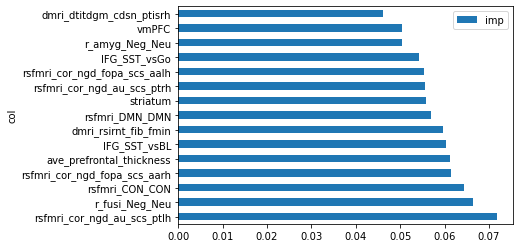

In [93]:
from sklearn.ensemble import RandomForestClassifier
imp = pd.DataFrame({'col':X.columns,'imp':rf.feature_importances_})
imp.sort_values('imp', ascending=False)[:15].plot('col','imp','barh')

##  XGB Regressor

In [94]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

# Define the model
xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', 
                           colsample_bytree = 0.3, 
                           learning_rate = 0.1,
                           max_depth = 5, 
                           alpha = 10, 
                           n_estimators = 100)

# Fit the model
model = xgb_reg.fit(X_train, y_train)

# Make predictions
y_train_pred_xgb = xgb_reg.predict(X_train)
y_test_pred_xgb = xgb_reg.predict(X_test)

# Calculate MSE
train_mse_xgb = mean_squared_error(y_train, y_train_pred_xgb)
test_mse_xgb = mean_squared_error(y_test, y_test_pred_xgb)

print(f'Training MSE: {train_mse_xgb}')
print(f'Test MSE: {test_mse_xgb}')

# Calculate R^2 Score
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)

print(f'Training R^2 Score: {r2_train_xgb}')
print(f'Test R^2 Score: {r2_test_xgb}')

Training MSE: 0.21898033746666482
Test MSE: 0.25771966934596924
Training R^2 Score: 0.19999231482357538
Test R^2 Score: -0.016732829323720777


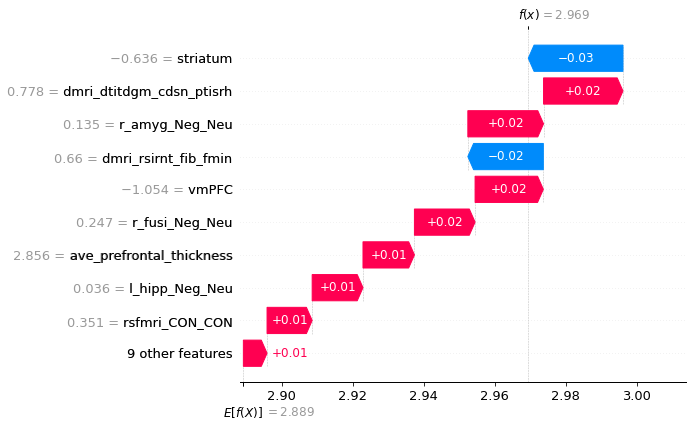

In [95]:

import shap

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

### SVC

In [96]:


from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define the model
svc = SVC(kernel='rbf', C=1.0)  # Adjust kernel and parameters as needed

# Fit the model
svc.fit(X_train, y_train)

# Make predictions
y_train_pred_svc = svc.predict(X_train)
y_test_pred_svc = svc.predict(X_test)

# Calculate accuracy
train_accuracy_svc = accuracy_score(y_train, y_train_pred_svc)
test_accuracy_svc = accuracy_score(y_test, y_test_pred_svc)

print(f'Training Accuracy: {train_accuracy_svc}')
print(f'Test Accuracy: {test_accuracy_svc}')

# Detailed classification report
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_svc))

# Confusion Matrix
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_svc))


Training Accuracy: 0.9549706330215357
Test Accuracy: 0.9591304347826087

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00         5
           3       0.96      1.00      0.98      1103

    accuracy                           0.96      1150
   macro avg       0.24      0.25      0.24      1150
weighted avg       0.92      0.96      0.94      1150


Confusion Matrix (Test):
[[   0    0    0   26]
 [   0    0    0   16]
 [   0    0    0    5]
 [   0    0    0 1103]]


/Users/carolynamir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carolynamir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carolynamir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [98]:
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np

# Define the model
svc = SVC(kernel='rbf', C=1.0)  # Adjust kernel and parameters as needed

# Fit the model
svc.fit(X_train, y_train)

# Make predictions
y_train_pred_svc = svc.predict(X_train)
y_test_pred_svc = svc.predict(X_test)

# Calculate accuracy
train_accuracy_svc = accuracy_score(y_train, y_train_pred_svc)
test_accuracy_svc = accuracy_score(y_test, y_test_pred_svc)

print(f'Training Accuracy: {train_accuracy_svc}')
print(f'Test Accuracy: {test_accuracy_svc}')

# Detailed classification report
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_svc))

# Confusion Matrix
print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, y_test_pred_svc))

# Feature importance for linear kernel
if svc.kernel == 'linear':  # Linear kernel allows access to coefficients
    feature_weights = pd.DataFrame({
        'Feature': X_train.columns,
        'Weight': svc.coef_[0]
    }).sort_values(by='Weight', ascending=False)

    print("\nFeature Weights (Linear Kernel):")
    print(feature_weights)
else:
    print("\nFeature importance is not directly available for non-linear kernels like RBF.")

# For approximate feature importance with RBF, use permutation importance or SHAP


Training Accuracy: 0.9549706330215357
Test Accuracy: 0.9591304347826087

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.00      0.00      0.00        16
           2       0.00      0.00      0.00         5
           3       0.96      1.00      0.98      1103

    accuracy                           0.96      1150
   macro avg       0.24      0.25      0.24      1150
weighted avg       0.92      0.96      0.94      1150


Confusion Matrix (Test):
[[   0    0    0   26]
 [   0    0    0   16]
 [   0    0    0    5]
 [   0    0    0 1103]]

Feature importance is not directly available for non-linear kernels like RBF.


/Users/carolynamir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carolynamir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/carolynamir/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


PermutationExplainer explainer: 1151it [2:13:44,  6.98s/it]                     


SHAP Waterfall Plot for the First Test Prediction:


ValueError: Image size of 276709119x427 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 576x468 with 3 Axes>


SHAP Summary Plot for Feature Importance:


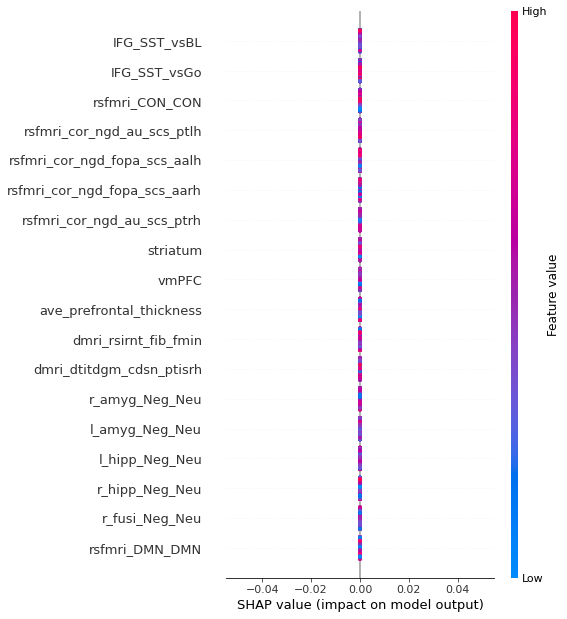


SHAP Bar Plot for Mean Feature Importance:


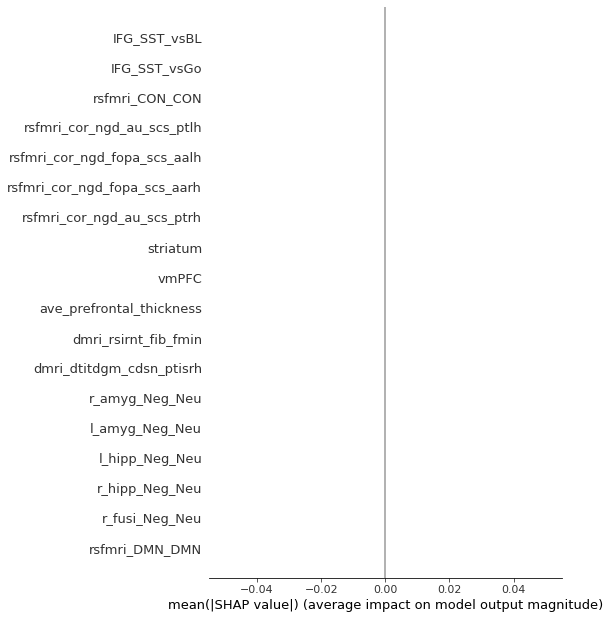

In [101]:
#this takes a very long time to run 

# import shap
# import matplotlib.pyplot as plt

# # Ensure the SHAP Explainer is compatible with the model
# explainer = shap.Explainer(svc.predict, X_train)  # Use `svc.predict` for classification

# # Compute SHAP values
# shap_values = explainer(X_test)

# # Visualize the first prediction's explanation
# print("SHAP Waterfall Plot for the First Test Prediction:")
# shap.plots.waterfall(shap_values[0])N

# # Visualize overall feature importance (summary plot)
# print("\nSHAP Summary Plot for Feature Importance:")
# shap.summary_plot(shap_values, X_test)

# # Bar plot of mean SHAP values by feature
# print("\nSHAP Bar Plot for Mean Feature Importance:")
# shap.summary_plot(shap_values, X_test, plot_type="bar")


In [102]:
import time
while True:
    time.sleep(300)  # Keeps the kernel alive every 5 minutes
    print("Kernel is still active...")

Kernel is still active...
Kernel is still active...


KeyboardInterrupt: 

In [100]:
import joblib
import os


# Save the `df` variable to the project directory
joblib.dump(df, os.path.join(project, 'df_workspace.pkl'))


['/Users/carolynamir/Documents/ABCD/df_workspace.pkl']

### Bagging

In [103]:
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the base model (Random Forest Regressor in this case)
base_model = RandomForestRegressor(n_estimators=100, random_state=0)  # Adjust parameters as needed

# Define the bagging regressor
bagging_model = BaggingRegressor(base_estimator=base_model, n_estimators=10, random_state=0)

# Fit the model
bagging_model.fit(X_train, y_train)

# Make predictions
y_train_pred_bagging = bagging_model.predict(X_train)
y_test_pred_bagging = bagging_model.predict(X_test)

# Calculate MSE
train_mse_bagging = mean_squared_error(y_train, y_train_pred_bagging)
test_mse_bagging = mean_squared_error(y_test, y_test_pred_bagging)

print(f'Training MSE: {train_mse_bagging}')
print(f'Test MSE: {test_mse_bagging}')

# Calculate R^2 Score
r2_train_bagging = r2_score(y_train, y_train_pred_bagging)
r2_test_bagging = r2_score(y_test, y_test_pred_bagging)

print(f'Training R^2 Score: {r2_train_bagging}')
print(f'Test R^2 Score: {r2_test_bagging}')

Training MSE: 0.10623693495758103
Test MSE: 0.2695856208695652
Training R^2 Score: 0.6118812976594723
Test R^2 Score: -0.0635453310463121


In [104]:

from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the base model (Random Forest Regressor in this case)
base_model = xgb.XGBRegressor(objective ='reg:squarederror', 
                           colsample_bytree = 0.3, 
                           learning_rate = 0.1,
                           max_depth = 5, 
                           alpha = 10, 
                           n_estimators = 200)

# Define the bagging regressor
bagging_model = BaggingRegressor(base_estimator=base_model, n_estimators=100, random_state=0)

# Fit the model
bagging_model.fit(X_train, y_train)

# Make predictions
y_train_pred_bagging = bagging_model.predict(X_train)
y_test_pred_bagging = bagging_model.predict(X_test)

# Calculate MSE
train_mse_bagging = mean_squared_error(y_train, y_train_pred_bagging)
test_mse_bagging = mean_squared_error(y_test, y_test_pred_bagging)

print(f'Training MSE: {train_mse_bagging}')
print(f'Test MSE: {test_mse_bagging}')

# Calculate R^2 Score
r2_train_bagging = r2_score(y_train, y_train_pred_bagging)
r2_test_bagging = r2_score(y_test, y_test_pred_bagging)

print(f'Training R^2 Score: {r2_train_bagging}')
print(f'Test R^2 Score: {r2_test_bagging}')

Training MSE: 0.1818825683745629
Test MSE: 0.2584361850809675
Training R^2 Score: 0.33552274974721275
Test R^2 Score: -0.019559563784262934


In [ ]:
### Regress out demo features first before running other models 

In [121]:
# Check for NaN values
print(X_demographic.isna().sum())
print(X_features.isna().sum())

# Check for infinite values
print((X_demographic == float('inf')).sum())
print((X_features == float('inf')).sum())


demo_sex_v2      0
interview_age    0
income_recode    0
dtype: int64
rsfmri_DMN_DMN                     0
rsfmri_CON_CON                     0
rsfmri_cor_ngd_au_scs_ptlh         0
rsfmri_cor_ngd_fopa_scs_aalh       0
rsfmri_cor_ngd_fopa_scs_aarh       0
rsfmri_cor_ngd_au_scs_ptrh         0
striatum                           0
vmPFC                              0
ave_prefrontal_thickness           0
dmri_rsirnt_fib_fmin               0
dmri_dtitdgm_cdsn_ptisrh           0
r_amyg_Neg_Neu                     0
l_amyg_Neg_Neu                     0
l_hipp_Neg_Neu                     0
r_hipp_Neg_Neu                     0
r_fusi_Neg_Neu                     0
IFG_SST_vsGo                       0
IFG_SST_vsBL                       0
PLESum                             0
PLEBother                          0
outcome_group                   5747
outcome_group_distress          5747
dtype: int64
demo_sex_v2      0
interview_age    0
income_recode    0
dtype: int64
rsfmri_DMN_DMN                  0

In [123]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Assuming 'df' is your DataFrame and 'demographic_cols' and 'target_col' are defined
demographic_cols = ['demo_sex_v2', 'interview_age','income_recode']  # replace with actual demographic columns
target_col = 'outcome_group_distress_karcher'  # the column you're trying to predict
feature_cols = X_cols

# 1. Separate out demographic features
X_demographic = df[demographic_cols]
X_features = df[feature_cols]
y = df[target_col]

# 2. Regress out the demographic features
regressor = LinearRegression()
regressor.fit(X_demographic, X_features)

# 3. Calculate residuals (features without demographic influence)
X_residuals = X_features - regressor.predict(X_demographic)

# 4. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_residuals, y, test_size=0.2, random_state=42)

# 5. Fit a classifier (e.g., RandomForest)
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# 6. Evaluate classifier
accuracy = classifier.score(X_test, y_test)
print(f'Classifier accuracy: {accuracy}')


Classifier accuracy: 0.9591304347826087


In [124]:
# Assess the model performance
train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)

print(f'Training MSE: {train_mse_rf}')
print(f'Test MSE: {test_mse_rf}')

# Calculate the r2 score for training data
r2_train_rf = r2_score(y_train, y_train_pred_rf)

# Calculate the r2 score for test data
r2_test_rf = r2_score(y_test, y_test_pred_rf)

print(f'Training R^2 Score: {r2_train_rf}')
print(f'Test R^2 Score: {r2_test_rf}')

Training MSE: 0.1440839096821841
Test MSE: 0.26287079398629276
Training R^2 Score: 0.4736137664708808
Test R^2 Score: -0.03705459034043468


In [125]:
importance_rf = rf.feature_importances_

# Map these values back to the corresponding features in your dataframe:
feature_importance_rf = pd.DataFrame(importance_rf, index=X.columns, columns=["Importance"])
print(feature_importance_rf.sort_values(by="Importance", ascending=False))

                              Importance
rsfmri_cor_ngd_au_scs_ptlh      0.071819
r_fusi_Neg_Neu                  0.066328
rsfmri_CON_CON                  0.064286
rsfmri_cor_ngd_fopa_scs_aarh    0.061474
ave_prefrontal_thickness        0.061207
IFG_SST_vsBL                    0.060223
dmri_rsirnt_fib_fmin            0.059551
rsfmri_DMN_DMN                  0.056834
striatum                        0.055892
rsfmri_cor_ngd_au_scs_ptrh      0.055691
rsfmri_cor_ngd_fopa_scs_aalh    0.055406
IFG_SST_vsGo                    0.054217
r_amyg_Neg_Neu                  0.050374
vmPFC                           0.050304
dmri_dtitdgm_cdsn_ptisrh        0.046238
l_amyg_Neg_Neu                  0.045974
l_hipp_Neg_Neu                  0.042249
r_hipp_Neg_Neu                  0.041932


In [140]:
df = df_copy
outcome_var = 'outcome_group_distress'
#df = df.dropna(subset=X_cols + [outcome_var])  # Drop rows with NaN in relevant columns

In [141]:
df[X_cols]

KeyboardInterrupt: 

In [135]:
df.columns

Index(['rsfmri_DMN_DMN', 'rsfmri_CON_CON', 'rsfmri_cor_ngd_au_scs_ptlh',
       'rsfmri_cor_ngd_fopa_scs_aalh', 'rsfmri_cor_ngd_fopa_scs_aarh',
       'rsfmri_cor_ngd_au_scs_ptrh', 'striatum', 'vmPFC',
       'ave_prefrontal_thickness', 'dmri_rsirnt_fib_fmin',
       'dmri_dtitdgm_cdsn_ptisrh', 'r_amyg_Neg_Neu', 'l_amyg_Neg_Neu',
       'l_hipp_Neg_Neu', 'r_hipp_Neg_Neu', 'r_fusi_Neg_Neu', 'IFG_SST_vsGo',
       'IFG_SST_vsBL', 'PLESum', 'PLEBother', 'demo_sex_v2', 'interview_age',
       'income_recode', 'outcome_group', 'outcome_group_distress',
       'outcome_group_distress_karcher'],
      dtype='object')

In [143]:
print(df[X_cols].head())

   rsfmri_DMN_DMN  rsfmri_CON_CON  rsfmri_cor_ngd_au_scs_ptlh  \
0             NaN             NaN                         NaN   
1        0.273000        0.350964                   -0.091419   
2        0.260493        0.301307                   -0.113760   
3        0.251705        0.211683                   -0.019446   
4        0.352653        0.323760                    0.178744   

   rsfmri_cor_ngd_fopa_scs_aalh  rsfmri_cor_ngd_fopa_scs_aarh  \
0                           NaN                           NaN   
1                     -0.039787                      0.022555   
2                     -0.105930                      0.059647   
3                      0.038358                      0.002575   
4                     -0.083397                     -0.079683   

   rsfmri_cor_ngd_au_scs_ptrh  striatum     vmPFC  ave_prefrontal_thickness  \
0                         NaN  1.043689  1.143153                  2.637667   
1                   -0.012228 -0.635862 -1.054433           

In [136]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the data
#df = pd.read_csv("your_dataframe.csv")

# Separate target variable (y) and predictors (X)
y = df["outcome_group"]
X = df[X_cols]  # Use the dynamically defined X_cols_2

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [162]:


from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# Fit the Elastic Net model
alpha_value = 0.01  # Regularization strength
l1_ratio_value = 0.5  # L1 ratio, 0.5 corresponds to a 50-50 mix of L1 and L2 regularization
elastic_net = ElasticNet(alpha=alpha_value, l1_ratio=l1_ratio_value)
elastic_net.fit(X_train_scaled, y_train)

# Make predictions using the model
y_train_pred_en = elastic_net.predict(X_train)
y_test_pred_en = elastic_net.predict(X_test)

# Calculate MSE
train_mse_en = mean_squared_error(y_train, y_train_pred_en)
test_mse_en = mean_squared_error(y_test, y_test_pred_en)

print(f'Training MSE: {train_mse_en}')
print(f'Test MSE: {test_mse_en}')

# Calculate R2 Score
r2_train_en = r2_score(y_train, y_train_pred_en)
r2_test_en = r2_score(y_test, y_test_pred_en)

print(f'Training R^2 Score: {r2_train_en}')
print(f'Test R^2 Score: {r2_test_en}')

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').